## 1. Import Library
___

In [1]:
import os
import gc
import ctypes
import sys
import random
from tqdm import tqdm

import shutil
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

import cv2
from PIL import Image

import torch
import torch.nn as nn

from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings('ignore')

#### Configuration

In [2]:
class CFG:
    output_dir = 'runs/detect'
    seed = 42

    img_size = [256,256]
    num_classes = 3 # Ulcer, Polyp, Cancer
    
    epoch = 5
    warmup_epoch = 0
    patience = 5
    batch = 16
    optimizer = 'AdamW'
    amp = True
    base_lr = 1e-3
    base_lr_min = 1e-3
    weight_decay = 1e-5

    conf = 0.0
    iou = 0.7
    max_det = 500

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Reproducibility

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

#### Clean_memory

In [4]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()

clean_memory()

## 2. Road and Read Data
___

In [5]:
df = pd.read_csv('/kaggle/input/metadataset/colonoscopy_data2.csv')
print('Shape of DataFrame: ', df.shape)
print(display(df))

Shape of DataFrame:  (2496, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1484.52,775.16;1516.82,710.56;1519.30,640.99;1...",rectangle,838.559006,149.068323,1519.304348,807.453416,ulcer
1,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1663.40,1478.26;1653.47,1426.09;1616.20,1388.8...",rectangle,1310.608696,1324.223602,1663.403727,1868.322981,ulcer
2,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"687.01,223.60;687.01,273.29;704.40,337.89;726....",rectangle,687.006211,168.944099,1591.354037,1465.838509,ulcer
3,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"826.14,1200.00;878.31,1207.45;932.97,1187.58;9...",rectangle,488.248447,434.782609,1007.503106,1207.453416,ulcer
4,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"575.20,1038.51;520.55,1050.93;468.37,1050.93;4...",rectangle,212.472050,725.465839,607.503106,1050.931677,ulcer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,2_2_05111.png,2048,2048,colonoscopy,1,1,polygon,"1113.11,963.83;1070.55,976.60;1032.26,995.74;1...",rectangle,898.212766,948.936170,1493.957447,1527.659574,polyp
2492,2_2_05112.png,2048,2048,colonoscopy,1,1,polygon,"1230.13,1397.87;1187.57,1408.51;1138.64,1425.5...",rectangle,866.297872,1370.212766,1821.617021,1889.361702,polyp
2493,2_2_05113.png,2048,2048,colonoscopy,1,1,polygon,"1021.62,642.55;979.06,653.19;938.64,668.09;898...",rectangle,810.978723,642.553192,1268.425532,1038.297872,polyp
2494,2_2_05114.png,2048,2048,colonoscopy,1,1,polygon,"883.32,972.34;845.02,997.87;806.72,1025.53;776...",rectangle,772.680851,970.212766,1121.617021,1223.404255,polyp


None


#### Image Path

In [6]:
train_id = [x.split('/')[-1] for x in glob('/kaggle/input/colonoscopy-256x256-resized-png/train/*.png')]
train_df = df[df['image_id'].isin(train_id)].reset_index(drop=True)
print('=> Number of Unique Image_id in Train: ', train_df.image_id.nunique())

image_path = {os.path.basename(x): x for x in glob('/kaggle/input/colonoscopy-256x256-resized-png/train/*.png')}

train_df['path'] =  train_df['image_id'].map(image_path)

=> Number of Unique Image_id in Train:  1596


#### Rescaling 0~1(Xmid, Ymid, Width, Height)

In [7]:
train_df['x_min'] = train_df['x_min'] / train_df['width']
train_df['y_min'] = train_df['y_min'] / train_df['height']

train_df['x_max'] = train_df['x_max'] / train_df['width']
train_df['y_max'] = train_df['y_max'] / train_df['height']

train_df['x_mid'] = (train_df['x_max'] + train_df['x_min']) / 2
train_df['y_mid'] = (train_df['y_max'] + train_df['y_min']) / 2

train_df['w'] = train_df['x_max'] - train_df['x_min'] 
train_df['h'] = train_df['y_max'] - train_df['y_min']

#### Split Train & Val

In [8]:
gkf = GroupKFold(n_splits=5)

for i, (_, val_idx) in enumerate(gkf.split(train_df, groups=train_df['image_id'])):
    train_df.loc[val_idx, 'fold'] = i

valid_df = train_df[train_df['fold'] == 0].reset_index(drop=True)
train_df = train_df[train_df['fold'] != 0].reset_index(drop=True)

print('Images in train_df: ', train_df['image_id'].nunique())
print('Images in valid_df: ', valid_df['image_id'].nunique())

Images in train_df:  1277
Images in valid_df:  319


## 3. Write Yacs File
___

In [9]:
#### lesion_label
## ulcer: 0
## polyp: 1
## cancer: 2

In [10]:
## Image
os.makedirs(f'{CFG.output_dir}/train/images', exist_ok=True)
os.makedirs(f'{CFG.output_dir}/val/images', exist_ok=True)

## Label
os.makedirs(f'{CFG.output_dir}/train/labels', exist_ok=True)
os.makedirs(f'{CFG.output_dir}/val/labels', exist_ok=True)

## Train 
train_files = train_df['path'].unique()
for file in tqdm(train_files, total=len(train_files), desc='Building Train Scripts'):
    shutil.copy(file, f'{CFG.output_dir}/train/images')

    image_id = file.split('/')[-1]
    label = train_df[train_df['image_id'] == image_id][['lesion_label','x_mid','y_mid','w','h']]

    label_path = os.path.join(f'{CFG.output_dir}/train/labels',f'{image_id.split(".")[0]}.txt')
    with open(label_path,'w') as f:
        for _, row in label.iterrows():
            f.write(f"{int(row['lesion_label'])} {row['x_mid']} {row['y_mid']} {row['w']} {row['h']}\n")
## Val
val_files = valid_df['path'].unique()
for file in tqdm(val_files, total=len(val_files), desc='Building Val Scripts'):
    shutil.copy(file, f'{CFG.output_dir}/val/images')

    image_id = file.split('/')[-1]
    label = valid_df[valid_df['image_id'] == image_id][['lesion_label','x_mid','y_mid','w','h']]

    label_path = os.path.join(f'{CFG.output_dir}/val/labels',f'{image_id.split(".")[0]}.txt')
    with open(label_path, 'w') as f:
        for _, row in label.iterrows():
            f.write(f"{int(row['lesion_label'])} {row['x_mid']} {row['y_mid']} {row['w']} {row['h']}\n")
            

Building Val Scripts: 100%|██████████| 319/319 [00:04<00:00, 73.54it/s]


In [11]:
import yaml

data = dict(
    train = f'{CFG.output_dir}/train/',
    val = f'{CFG.output_dir}/val/',
    nc = CFG.num_classes,
    names = ['ulcer','polyp','cancer'],)

with open('/kaggle/working/colonoscopy.yaml', 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

In [12]:
with open('/kaggle/working/colonoscopy.yaml', 'r') as f:
    print(f.read())

names:
- ulcer
- polyp
- cancer
nc: 3
train: runs/detect/train/
val: runs/detect/val/



## 4. Train Yolo Vit Model
___

In [13]:
print(f'{Fore.LIGHTGREEN_EX}Installing ultralytics')
!pip install -q ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.83 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6170.0/8062.4 GB disk)


In [14]:
from ultralytics import RTDETR

In [15]:
model = RTDETR('rtdetr-l.pt')

100%|██████████| 63.4M/63.4M [00:00<00:00, 76.5MB/s]


In [16]:
model.train(
            ### Training Settings
            data='/kaggle/working/colonoscopy.yaml', # path to data file, i.e. coco8.yaml
            epochs=CFG.epoch, # (int) number of epochs to train for
            patience=CFG.patience, # (int) epochs to wait for no observable improvement
            imgsz=CFG.img_size[0], # (int | list) input images size(default: 640) # list[h,w]  
            batch=CFG.batch, # (int) number of images per batch (-1 for AutoBatch) # default: 16
            device=0, # device=0,1,2,3, device=cpu
            save=True, # save train checkpoints and predict results
            cache='disk', # Use cache for data loading
            verbose=True,
            exist_ok = True, # whether to overwrite existing experiment
            project = f'/kaggle/working/{CFG.output_dir}',
            seed = CFG.seed, 
            optimizer= CFG.optimizer, # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
            close_mosaic=5, # disable mosaic augmentations for final epochs
            cos_lr = True,
            amp= CFG.amp, # Automatic Mixed Precision(AMP) training
    
            ### HyperParameters
            lr0 = CFG.base_lr, # initial learning rate(i.e. SGD: 1e-2, Adam: 1e-3)
            lrf = CFG.base_lr_min, # final learning rate(1r0*1rf)
            weight_decay = CFG.weight_decay,
            warmup_epochs = CFG.warmup_epoch, # default:3
            hsv_h = 0, # (float) Hue Augmentation(fraction) # 색상 변화(빨강 -> 오렌지 -> 노랑색)
            hsv_s = 0.2, # (float) Saturation Augmentation(fraction) # 선명하거나, 흐릿하거나
            hsv_v = 0, # (float) Value Augmentation(fraction) # 밝아지거나, 어두워지거나
            degrees=2.5, # (float) image rotation (+/- deg)
            translate=0.01, # (float) image transflation (+/- fraction)
            scale = 0.1, # (float) image scale(+/- gain)
            shear = 0, # (float) image shear (+/- deg)
            flipud= 0.0, fliplr= 0.5, # vertical & horizontal flip  
            mosaic = 0.05, # (float) image mosaic(probability)
            mixup = 0.05, # (float) image mixup(probability)
            erasing = 0,

            ### Val/Test Settings
            val = False, # validate/test during training, # Epoch마다 평가함(False이면 맨마지막에만 평가함)
            split = 'val', # dataset split to use for validation
            conf = CFG.conf, # default: val(0.001), predict(0.25)
            iou = CFG.iou, # Iou threshold for NMS
            max_det = CFG.max_det, # default: 300
            plots = True, # save plots and images during train/val
           )

Ultralytics 8.3.83 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=rtdetr-l.pt, data=/kaggle/working/colonoscopy.yaml, epochs=5, time=None, patience=5, batch=16, imgsz=256, save=True, save_period=-1, cache=disk, device=0, workers=8, project=/kaggle/working/runs/detect, name=train, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=5, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=0.0, iou=0.7, max_det=500, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

100%|██████████| 755k/755k [00:00<00:00, 27.1MB/s]


Overriding model.yaml nc=80 with nc=3
WARNING ⚠️ no model scale passed. Assuming scale='l'.

                   from  n    params  module                                       arguments                     
  0                  -1  1     25248  ultralytics.nn.modules.block.HGStem          [3, 32, 48]                   
  1                  -1  6    155072  ultralytics.nn.modules.block.HGBlock         [48, 48, 128, 3, 6]           
  2                  -1  1      1408  ultralytics.nn.modules.conv.DWConv           [128, 128, 3, 2, 1, False]    
  3                  -1  6    839296  ultralytics.nn.modules.block.HGBlock         [128, 96, 512, 3, 6]          
  4                  -1  1      5632  ultralytics.nn.modules.conv.DWConv           [512, 512, 3, 2, 1, False]    
  5                  -1  6   1695360  ultralytics.nn.modules.block.HGBlock         [512, 192, 1024, 5, 6, True, False]
  6                  -1  6   2055808  ultralytics.nn.modules.block.HGBlock         [1024, 192, 1024, 5, 

100%|██████████| 5.35M/5.35M [00:00<00:00, 109MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/runs/detect/train/labels... 1277 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1277/1277 [00:01<00:00, 1152.16it/s]

train: WARNING ⚠️ /kaggle/working/runs/detect/train/images/2_1_00090.png: 1 duplicate labels removed
train: New cache created: /kaggle/working/runs/detect/train/labels.cache



train: Caching images (0.2GB Disk): 100%|██████████| 1277/1277 [00:01<00:00, 979.56it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/runs/detect/val/labels... 319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 319/319 [00:00<00:00, 962.99it/s]

val: WARNING ⚠️ /kaggle/working/runs/detect/val/images/2_1_00009.png: 5 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/runs/detect/val/images/2_1_00053.png: 3 duplicate labels removed
val: New cache created: /kaggle/working/runs/detect/val/labels.cache



val: Caching images (0.1GB Disk): 100%|██████████| 319/319 [00:00<00:00, 960.15it/s]


Plotting labels to /kaggle/working/runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 143 weight(decay=0.0), 206 weight(decay=1e-05), 226 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/detect/train
Starting training for 5 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


        1/5      5.96G     0.8596      45.54     0.9175         13        256: 100%|██████████| 80/80 [00:42<00:00,  1.86it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


        2/5      5.89G       0.52      1.511     0.5207         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.91it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


        3/5      5.29G     0.4356      1.179     0.4356         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


        4/5      5.88G     0.3922      1.048     0.3963         15        256: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


        5/5      5.29G     0.3686      0.942      0.375         14        256: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


                   all        319        392      0.618      0.645      0.622      0.423

5 epochs completed in 0.066 hours.
Optimizer stripped from /kaggle/working/runs/detect/train/weights/last.pt, 66.1MB
Optimizer stripped from /kaggle/working/runs/detect/train/weights/best.pt, 66.1MB

Validating /kaggle/working/runs/detect/train/weights/best.pt...
Ultralytics 8.3.83 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
rt-detr-l summary: 302 layers, 31,989,905 parameters, 0 gradients, 103.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


                   all        319        392      0.617      0.648      0.622      0.422
                 ulcer         78        143      0.549      0.385      0.386      0.158
                 polyp         82         90      0.624      0.767      0.735      0.595
                cancer        159        159      0.677      0.792      0.744      0.514
Speed: 0.1ms preprocess, 5.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79eeb9a436a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [17]:
!ls /kaggle/working/runs/detect/train/

args.yaml					  results.csv
confusion_matrix_normalized.png			  results.png
confusion_matrix.png				  train_batch0.jpg
events.out.tfevents.1741149273.10bbbdc6d487.18.0  train_batch1.jpg
F1_curve.png					  train_batch2.jpg
images						  val_batch0_labels.jpg
labels						  val_batch0_pred.jpg
labels.cache					  val_batch1_labels.jpg
labels_correlogram.jpg				  val_batch1_pred.jpg
labels.jpg					  val_batch2_labels.jpg
P_curve.png					  val_batch2_pred.jpg
PR_curve.png					  weights
R_curve.png


#### Loss Plot

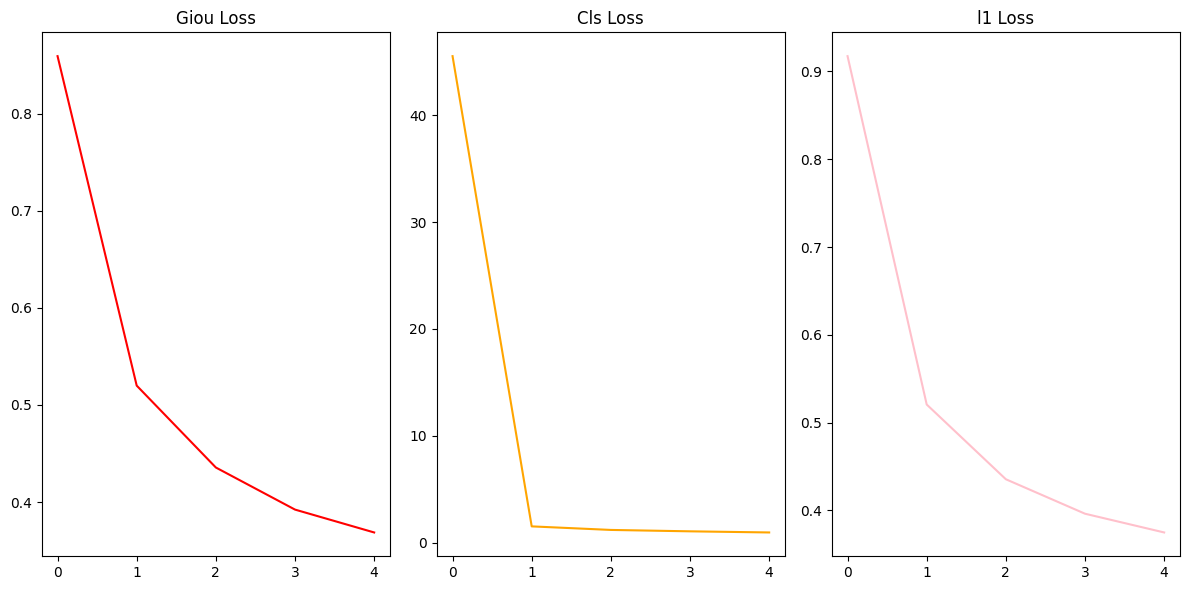

In [18]:
mdf = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title('Giou Loss')
mdf1 = mdf[~mdf['train/giou_loss'].isna()]
mdf1['train/giou_loss'].plot(color='red')
plt.subplot(1,3,2)
plt.title('Cls Loss')
mdf2 = mdf[~mdf['train/cls_loss'].isna()]
mdf2['train/cls_loss'].plot(color='orange')
plt.subplot(1,3,3)
plt.title('l1 Loss')
mdf3 = mdf[~mdf['train/l1_loss'].isna()]
mdf3['train/l1_loss'].plot(color='pink')

plt.tight_layout()
plt.show()

#### GT vs Predict

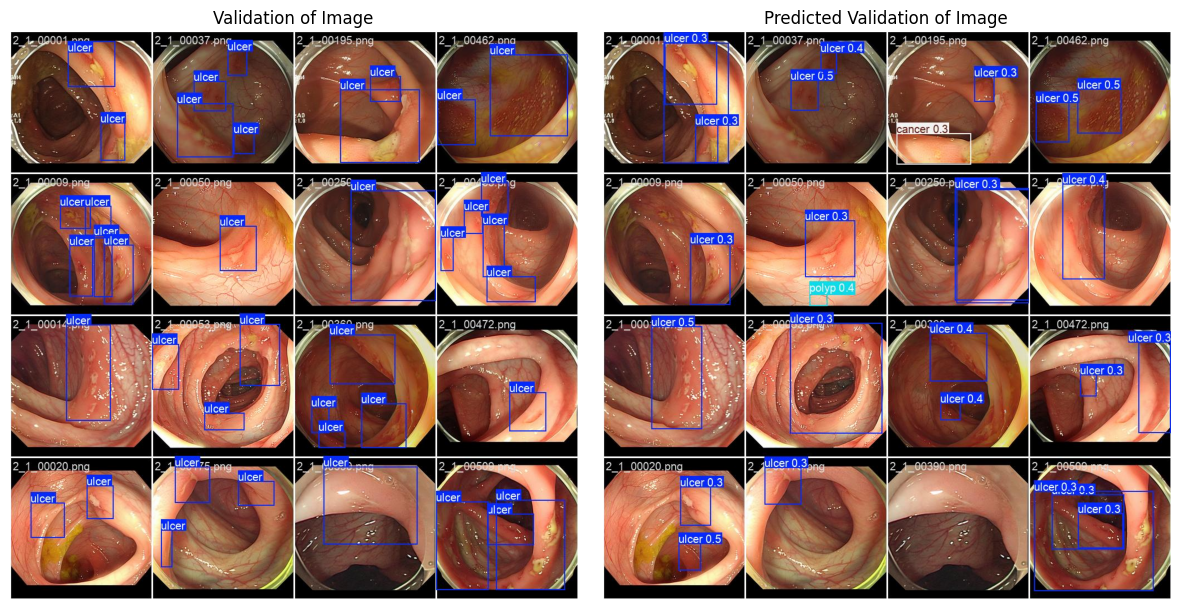

In [19]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
img = Image.open('/kaggle/working/runs/detect/train/val_batch0_labels.jpg')
img = np.array(img)
plt.title('Validation of Image')
plt.imshow(img)   
plt.axis('off')
    
plt.subplot(1,2,2)
img = Image.open('/kaggle/working/runs/detect/train/val_batch0_pred.jpg')
img = np.array(img)
plt.title('Predicted Validation of Image')
plt.imshow(img) 
plt.axis('off')

plt.tight_layout()
plt.show()

#### F1 Score & Precision & Recall

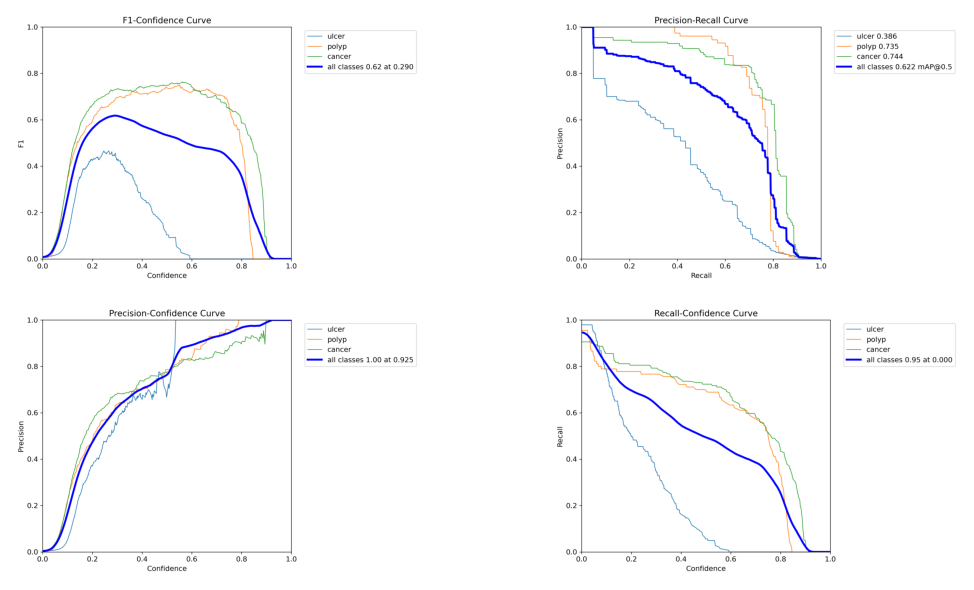

In [20]:
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
img = Image.open('/kaggle/working/runs/detect/train/F1_curve.png')
img = np.array(img)
plt.imshow(img)   
plt.axis('off')

plt.subplot(2,2,2)
img = Image.open('/kaggle/working/runs/detect/train/PR_curve.png')
img = np.array(img)
plt.imshow(img)   
plt.axis('off')

plt.subplot(2,2,3)
img = Image.open('/kaggle/working/runs/detect/train/P_curve.png')
img = np.array(img)
plt.imshow(img)   
plt.axis('off')

plt.subplot(2,2,4)
img = Image.open('/kaggle/working/runs/detect/train/R_curve.png')
img = np.array(img)
plt.imshow(img)   
plt.axis('off')



plt.tight_layout()
plt.show()

## 5. Evaluation

In [21]:
model = RTDETR('rtdetr-l.pt')
model = RTDETR(f'/kaggle/working/{CFG.output_dir}/train/weights/best.pt')

In [22]:
metrics = model.val(data='/kaggle/working/colonoscopy.yaml', imgsz=CFG.img_size[0], batch=CFG.batch*2, conf=CFG.conf, iou=CFG.iou, device=[0], 
                                project='runs/detect/val', name='metrics')

Ultralytics 8.3.83 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
rt-detr-l summary: 302 layers, 31,989,905 parameters, 0 gradients, 103.4 GFLOPs


val: Scanning /kaggle/working/runs/detect/val/labels.cache... 319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 319/319 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/runs/detect/val/images/2_1_00009.png: 5 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/runs/detect/val/images/2_1_00053.png: 3 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


                   all        319        392      0.622      0.645      0.625      0.425
                 ulcer         78        143      0.552      0.371      0.386      0.159
                 polyp         82         90      0.631      0.767      0.736      0.596
                cancer        159        159      0.684      0.799      0.753       0.52
Speed: 0.3ms preprocess, 5.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val/metrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 9.8 MB/s eta 0:00:00


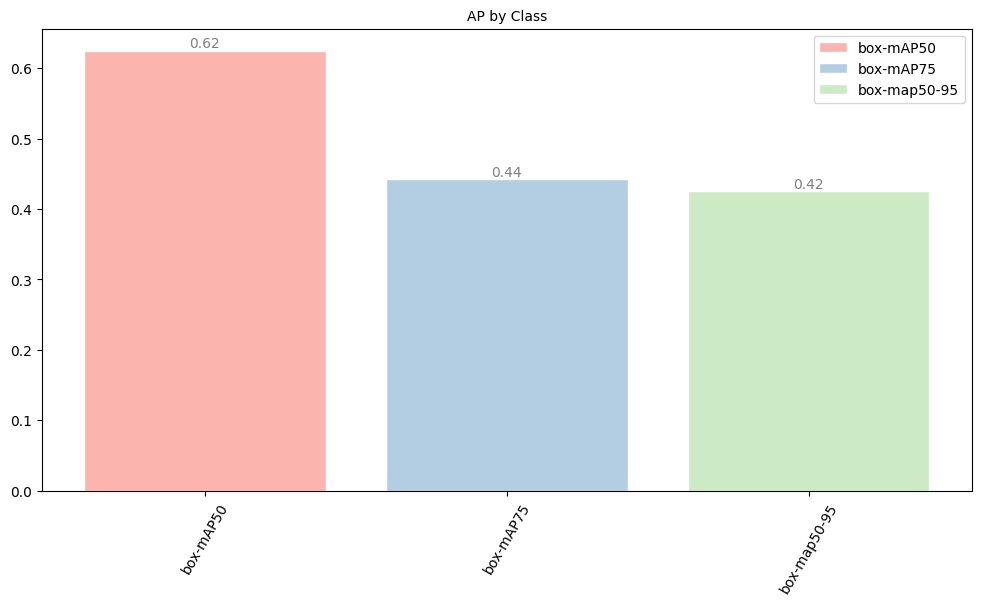

In [23]:
!pip -q install palettable
import palettable.colorbrewer.qualitative as pbq

plt.style.use('default')
plt.figure(figsize=(12,6))


plt.title('AP by Class', size=10)
ax = plt.bar(
    x=['box-mAP50','box-mAP75','box-map50-95'],
    height= [metrics.box.map50, metrics.box.map75, metrics.box.map],
    color=pbq.Pastel1_7.hex_colors,
    edgecolor='white',
    label=['box-mAP50','box-mAP75','box-map50-95']
)

# 막대 위에 텍스트 추가
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정


plt.legend()
plt.xticks(rotation=60)
plt.show()

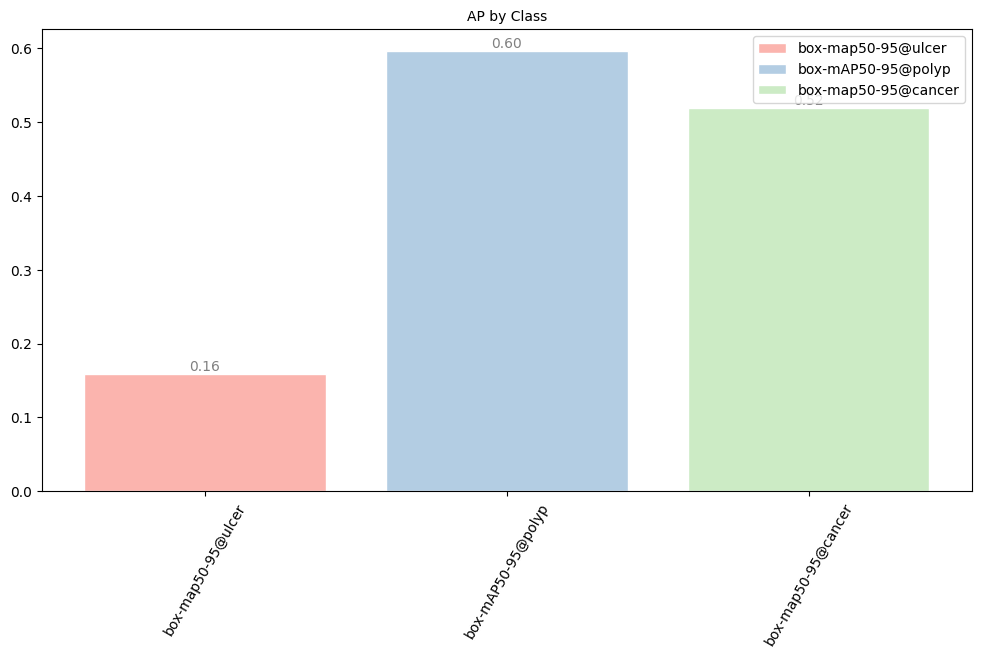

In [24]:
!pip -q install palettable
import palettable.colorbrewer.qualitative as pbq

plt.style.use('default')
plt.figure(figsize=(12,6))


plt.title('AP by Class', size=10)
ax = plt.bar(
    x=['box-map50-95@ulcer','box-mAP50-95@polyp','box-map50-95@cancer'],
    height= [metrics.box.maps[0], metrics.box.maps[1], metrics.box.maps[2]],
    color=pbq.Pastel1_7.hex_colors,
    edgecolor='white',
    label=['box-map50-95@ulcer','box-mAP50-95@polyp','box-map50-95@cancer']
)

# 막대 위에 텍스트 추가
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정


plt.legend()
plt.xticks(rotation=60)
plt.show()